In [1]:
Alpha_Name = "AlphaNet_Original_Input_5d_return"
start_time = "2020-01-01"
forecast_months = 6 # months
feat_num = 9
sequence = 3

In [2]:
import os
from os import walk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as Data
import torch.optim as optim
from torch.autograd import Variable
from progressbar import ProgressBar
from tqdm import tqdm
import time
import multiprocessing as mp
import sys
sys.path.append("/home/wuwenjun/jupyter_code/Shannon/AlphaNet")
path = '/home/wuwenjun/Data/' + Alpha_Name +'/'
output_path = "/home/wuwenjun/Alpha_Factor/" + "LSTM_" + Alpha_Name + "/result/"
model_dir = "/home/wuwenjun/Alpha_Factor/" + "LSTM_" + Alpha_Name + "/model/"
input_length = feat_num * (feat_num - 1) + 4 * feat_num
if os.path.exists(output_path) == False:
    os.makedirs(output_path)
    print(output_path)

In [3]:
time_list = []
data_path = path + "Final/"
dataframe_list = pd.DataFrame()
for f, _, i in walk(data_path):
    for j in tqdm(i):
        time_list.append(j)
time_list.sort()     
for count,item in enumerate(time_list):
    if item.startswith(start_time):
        train_timestamp = time_list[:count]
        test_timestamp = time_list[count:count + forecast_months//3]
        break
display(train_timestamp)
display(test_timestamp)

model_path = (model_dir + test_timestamp[0].split("_")[0] + "_" + test_timestamp[-1].split("_")[-1]).replace(".par","/")
if os.path.exists(model_path) == False:
    os.makedirs(model_path)
    print(model_path)

100%|██████████| 26/26 [00:00<00:00, 152520.15it/s]


['2015-01-01_2015-03-01.par',
 '2015-03-01_2015-06-01.par',
 '2015-06-01_2015-09-01.par',
 '2015-09-01_2016-01-01.par',
 '2016-01-01_2016-03-01.par',
 '2016-03-01_2016-06-01.par',
 '2016-06-01_2016-09-01.par',
 '2016-09-01_2017-01-01.par',
 '2017-01-01_2017-03-01.par',
 '2017-03-01_2017-06-01.par',
 '2017-06-01_2017-09-01.par',
 '2017-09-01_2018-01-01.par',
 '2018-01-01_2018-03-01.par',
 '2018-03-01_2018-06-01.par',
 '2018-06-01_2018-09-01.par',
 '2018-09-01_2019-01-01.par',
 '2019-01-01_2019-03-01.par',
 '2019-03-01_2019-06-01.par',
 '2019-06-01_2019-09-01.par',
 '2019-09-01_2020-01-01.par']

['2020-01-01_2020-03-01.par', '2020-03-01_2020-06-01.par']

In [4]:
trainx , trainy , testx , testy = [] , [] , [],  []

for train in tqdm(train_timestamp):
    df = pd.read_parquet(path+ "Final/" + train).set_index(["timestamp","ticker"])
    trainx.append(df.drop("target",axis=1))
    trainy.append(df['target'])
trainx = pd.concat(trainx,axis=0)
trainy = pd.concat(trainy,axis=0)

display(trainx)
display(trainy)


for test in tqdm(test_timestamp):
    df = pd.read_parquet(path+ "Final/" + test).set_index(["timestamp","ticker"])
    testx.append(df.drop("target",axis=1))
    testy.append(df['target'])
testx = pd.concat(testx,axis=0)
testy = pd.concat(testy,axis=0)
target_list = pd.DataFrame(testy.copy())
display(testx)
display(testy)

100%|██████████| 20/20 [00:41<00:00,  2.06s/it]


,,0,1,2,3,4,5,6,7,8,9,...,314,315,316,317,318,319,320,321,322,323
timestamp,ticker,,,,,,,,,,,,,,,,,,,,,
2015-02-16 09:30:00,1,1047.509016,165.116922,249.851660,924.464829,243.390500,183.194222,926.891342,158.088300,78.887819,957.587687,...,861850.412364,0.138453,-0.376716,0.284385,1.522075,1.245018,0.876160,3.017927,2.468587,1.737222
2015-02-17 09:30:00,1,1284.106922,304.746632,233.319300,1251.132811,325.347890,190.544389,1311.161194,268.878420,78.529422,1262.525551,...,825372.445636,-1.631951,-0.601635,0.240629,1.601496,1.147820,0.839082,3.175407,2.275878,1.663689
2015-02-25 09:30:00,1,1515.538580,320.840611,242.242430,1522.025569,325.437271,214.401980,1539.154187,259.118036,99.405562,1482.690747,...,784033.056545,-1.377793,-0.151133,0.292173,1.574869,1.078356,0.797058,3.122595,2.138158,1.580369
2015-02-26 09:30:00,1,1466.712161,355.378729,244.332118,1546.573639,318.650776,222.730596,1381.349806,297.507667,108.085628,1469.916341,...,727636.666545,-0.375218,-0.482991,0.038896,1.643798,1.006125,0.739729,3.259280,1.994944,1.466684
2015-02-27 09:30:00,1,1271.480107,335.406489,121.012389,1338.104279,252.973056,186.957378,1296.812044,215.993378,108.132489,1324.356569,...,756908.456182,-0.411738,-0.287113,0.381687,1.581575,1.159289,0.769491,3.135918,2.298631,1.525691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25 09:30:00,688389,0.717597,0.132396,0.128393,0.573326,0.154487,0.067029,0.595819,0.098409,0.058362,0.648569,...,32752.930545,-1.494300,1.104107,-0.019865,12.889787,11.698700,9.424807,12.889787,11.698700,9.424807
2019-12-26 09:30:00,688389,0.687183,0.164358,0.126508,0.560489,0.174990,0.069812,0.537811,0.106142,0.065703,0.621105,...,32703.618545,-1.062827,0.276873,0.323804,11.736496,12.433038,9.410618,11.736496,12.433038,9.410618
2019-12-27 09:30:00,688389,0.404211,0.170479,0.135013,0.300933,0.185134,0.078756,0.254311,0.104358,0.078968,0.361575,...,33045.135455,-0.579624,0.041667,0.748616,10.971425,12.116078,9.508887,10.971425,12.116078,9.508887


timestamp            ticker
2015-02-16 09:30:00  1        -0.679514
2015-02-17 09:30:00  1        -0.824485
2015-02-25 09:30:00  1        -0.790990
2015-02-26 09:30:00  1        -1.006040
2015-02-27 09:30:00  1        -1.213373
                                 ...   
2019-12-25 09:30:00  688389   -0.559038
2019-12-26 09:30:00  688389   -0.477997
2019-12-27 09:30:00  688389   -0.430200
2019-12-30 09:30:00  688389   -0.053279
2019-12-31 09:30:00  688389    0.128167
Name: target, Length: 3796142, dtype: float64

100%|██████████| 2/2 [00:04<00:00,  2.06s/it]


,,0,1,2,3,4,5,6,7,8,9,...,314,315,316,317,318,319,320,321,322,323
timestamp,ticker,,,,,,,,,,,,,,,,,,,,,
2020-01-02 09:30:00,1,930.974427,1189.989146,119.823498,586.173551,907.109662,21.270372,496.040438,1211.632566,-6.310924,631.520977,...,700216.562182,-0.252885,1.034487,-0.018404,0.309860,0.422665,0.360829,0.699122,0.953624,0.814091
2020-01-03 09:30:00,1,508.189413,1817.282544,180.232144,349.191600,1607.496633,78.309228,322.570358,1710.834244,72.834889,381.417755,...,854750.234364,-0.309947,0.868576,0.450520,0.289802,0.428480,0.440453,0.653875,0.966715,0.993758
2020-01-06 09:30:00,1,492.936747,2311.944122,514.146293,303.935648,2161.603100,392.997612,253.344154,2131.751233,428.736718,338.487834,...,920674.613091,-0.105327,0.834089,0.738505,0.284040,0.420340,0.474427,0.640862,0.948355,1.070400
2020-01-07 09:30:00,1,331.524773,2620.202889,851.192272,198.404656,2542.934233,698.930000,192.341922,2435.144200,710.393833,206.378208,...,932384.970909,0.143989,0.748438,0.552495,0.294860,0.408182,0.480455,0.665276,0.920927,1.084018
2020-01-08 09:30:00,1,289.239351,2774.701947,1175.553790,162.295658,2539.000353,1066.541230,120.383682,2241.527818,1086.483654,147.365655,...,915870.519273,-0.079424,0.250896,0.584156,0.296269,0.403353,0.471953,0.668451,0.910013,1.064818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-25 09:30:00,688399,145.058544,102.900373,291.804320,96.556694,98.291493,310.663984,135.863911,83.149802,208.860347,115.710131,...,29397.982364,5.979449,1.024996,-0.270202,16.970444,19.273864,22.039995,16.970444,19.273864,22.039995
2020-05-26 09:30:00,688399,188.140111,73.147256,141.024870,137.441784,69.128806,153.068290,163.341413,51.128161,98.400247,157.379208,...,27335.442182,4.343320,3.362193,-0.479024,17.499125,19.485409,20.493689,17.499125,19.485409,20.493689
2020-05-27 09:30:00,688399,250.251258,116.622329,92.636120,199.366691,104.925807,100.881953,236.665444,97.351904,42.759193,223.721218,...,25205.631636,6.939820,3.436735,-0.352345,19.836240,20.228593,18.896940,19.836240,20.228593,18.896940


timestamp            ticker
2020-01-02 09:30:00  1        -0.486757
2020-01-03 09:30:00  1        -0.910133
2020-01-06 09:30:00  1        -0.852201
2020-01-07 09:30:00  1        -0.461992
2020-01-08 09:30:00  1        -0.377981
                                 ...   
2020-05-25 09:30:00  688399    0.702991
2020-05-26 09:30:00  688399    0.940820
2020-05-27 09:30:00  688399    0.229983
2020-05-28 09:30:00  688399   -0.946442
2020-05-29 09:30:00  688399   -0.852920
Name: target, Length: 365230, dtype: float64

In [5]:
# Reshape
trainx = torch.from_numpy(np.array(trainx).reshape(-1,input_length,sequence))
trainy = torch.from_numpy(np.array(trainy).reshape(-1,1))
testx = torch.from_numpy(np.array(testx).reshape(-1,input_length,sequence))
testy = torch.from_numpy(np.array(testy).reshape(-1,1))
print("trainx.shape: " , trainx.shape)
print("trainy.shape: " , trainy.shape)
print("testx.shape: " , testx.shape)
print("testy.shape: " , testy.shape)

trainx.shape:  torch.Size([3796142, 108, 3])
trainy.shape:  torch.Size([3796142, 1])
testx.shape:  torch.Size([365230, 108, 3])
testy.shape:  torch.Size([365230, 1])


In [16]:
a = pd.read_parquet("//home/wuwenjun/Data/AlphaNet_Original_Input_12.14/Cov/2015-01-01_2015-03-01.par")
np.array(a.set_index(["timestamp","ticker"]))[0]

array([ 1.04750902e+03,  1.65116922e+02,  2.49851660e+02,  9.24464829e+02,
        2.43390500e+02,  1.83194222e+02,  9.26891342e+02,  1.58088300e+02,
        7.88878189e+01,  9.57587687e+02,  1.86292675e+02,  2.29790234e+02,
        1.37068107e+07, -8.91245480e+05,  4.31345384e+06, -1.98829705e+01,
       -6.59192856e+00,  5.30522444e-02,  1.39344223e+01, -9.06152222e-01,
        4.38510846e+00,  2.76280152e+01, -1.79640700e+00,  8.69465368e+00,
        8.87325873e+02,  1.75757296e+02,  1.50877611e+02,  9.95996587e+02,
        1.93734324e+02,  8.11814422e+01,  1.05896939e+03,  2.11033576e+02,
        2.06326668e+02,  1.87056244e+07,  3.77890563e+06,  4.23844474e+06,
       -1.73888487e+00, -5.89884489e+00,  3.23170376e+00,  1.90160228e+01,
        3.84142404e+00,  4.30883549e+00,  3.77043375e+01,  7.61720067e+00,
        8.54345216e+00,  8.31918736e+02,  2.03409598e+02,  1.07275600e+02,
        8.46815213e+02,  2.15937542e+02,  1.66936643e+02,  1.10936672e+07,
       -9.83652602e+05,  

In [6]:
train_dataset = Data.TensorDataset(trainx, trainy)
test_dataset = Data.TensorDataset(testx, testy)
batch_size = 1024
train_loader = Data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=16,
    pin_memory=True
)

test_loader = Data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=16,
    pin_memory=True
)

In [7]:
from AlphaNet.Models import AlphaNet_LSTM_V1
from AlphaNet import Model_Loader
LR = 0.001
epoch_num = 10
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
loss_function = nn.MSELoss()


model = AlphaNet_LSTM_V1(input_length, 30)
optimizer = optim.Adam(model.parameters(), lr=LR)
model_loader = Model_Loader(model = model,device=device)
print(model_loader.model)

AlphaNet_LSTM_V1(
  (batch): BatchNorm1d(108, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(108, 30, num_layers=2, batch_first=True, bidirectional=True)
  (batch2): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=30, out_features=1, bias=True)
)


  0%|          | 0/10 [00:00<?, ?it/s]

Learning Rate is : 0.01


 10%|█         | 1/10 [01:15<11:16, 75.22s/it]

Epoch:  1  loss:  0.8398897760601907


 20%|██        | 2/10 [03:32<14:54, 111.82s/it]

Epoch:  2  loss:  0.835764451195784


 30%|███       | 3/10 [04:44<10:54, 93.57s/it] 

Epoch:  3  loss:  0.8350638829015337


 40%|████      | 4/10 [07:30<12:14, 122.35s/it]

Epoch:  4  loss:  0.8341741660263082


 50%|█████     | 5/10 [08:38<08:32, 102.44s/it]

Epoch:  5  loss:  0.8341498205136602


 60%|██████    | 6/10 [10:54<07:35, 113.89s/it]

Epoch:  6  loss:  0.8343498468771564


 70%|███████   | 7/10 [12:49<05:43, 114.35s/it]

Epoch:  7  loss:  0.8345573529031933


 80%|████████  | 8/10 [15:19<04:11, 125.79s/it]

Epoch:  8  loss:  0.8343789190596572


 90%|█████████ | 9/10 [17:19<02:03, 123.81s/it]

Epoch:  9  loss:  0.8346591844534451


100%|██████████| 10/10 [20:11<00:00, 121.17s/it]

Epoch:  10  loss:  0.8345939705851815


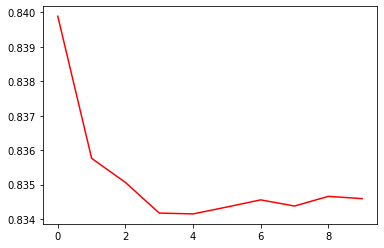

In [9]:
model = model_loader.fit_transform(train_loader,optimizer,loss_function,epoch_num,save_path = model_path)

  0%|          | 0/30 [00:00<?, ?it/s]

Learning Rate is : 0.001


  3%|▎         | 1/30 [01:22<39:45, 82.27s/it]

Epoch:  1  loss:  0.8314772995159684


  7%|▋         | 2/30 [03:44<54:56, 117.72s/it]

Epoch:  2  loss:  0.8304505634731189


 10%|█         | 3/30 [04:55<43:17, 96.19s/it] 

Epoch:  3  loss:  0.8299618760996735


 13%|█▎        | 4/30 [07:05<47:30, 109.62s/it]

Epoch:  4  loss:  0.8293931614288983


 17%|█▋        | 5/30 [10:49<1:02:52, 150.89s/it]

Epoch:  5  loss:  0.828898861436401


 20%|██        | 6/30 [13:13<59:24, 148.53s/it]  

Epoch:  6  loss:  0.8287327702152165


 23%|██▎       | 7/30 [14:30<47:59, 125.19s/it]

Epoch:  7  loss:  0.828424635175388


 27%|██▋       | 8/30 [17:09<49:47, 135.80s/it]

Epoch:  8  loss:  0.8283286149541738


 30%|███       | 9/30 [19:27<47:49, 136.63s/it]

Epoch:  9  loss:  0.8278566674818943


 33%|███▎      | 10/30 [21:08<41:51, 125.60s/it]

Epoch:  10  loss:  0.8276056359876042


 37%|███▋      | 11/30 [23:26<40:58, 129.40s/it]

Epoch:  11  loss:  0.8274300730913954


 40%|████      | 12/30 [25:13<36:47, 122.62s/it]

Epoch:  12  loss:  0.8272569863013499


 43%|████▎     | 13/30 [27:02<33:32, 118.39s/it]

Epoch:  13  loss:  0.8269709253092482


 47%|████▋     | 14/30 [29:37<34:32, 129.50s/it]

Epoch:  14  loss:  0.8270618135365947


 50%|█████     | 15/30 [33:21<39:28, 157.91s/it]

Epoch:  15  loss:  0.8268133420112767


 53%|█████▎    | 16/30 [36:17<38:08, 163.49s/it]

Epoch:  16  loss:  0.8265941611836839


 57%|█████▋    | 17/30 [39:40<37:59, 175.37s/it]

Epoch:  17  loss:  0.8263655246180952


 60%|██████    | 18/30 [40:56<29:04, 145.39s/it]

Epoch:  18  loss:  0.826324444168485


 63%|██████▎   | 19/30 [43:54<28:28, 155.29s/it]

Epoch:  19  loss:  0.8263772483267288


 67%|██████▋   | 20/30 [45:42<23:31, 141.14s/it]

Epoch:  20  loss:  0.8260613037046658


 70%|███████   | 21/30 [47:27<19:31, 130.12s/it]

Epoch:  21  loss:  0.8260010696806477


 73%|███████▎  | 22/30 [49:22<16:45, 125.72s/it]

Epoch:  22  loss:  0.8260371134748907


 77%|███████▋  | 23/30 [51:43<15:11, 130.21s/it]

Epoch:  23  loss:  0.82567973406222


 80%|████████  | 24/30 [53:23<12:06, 121.14s/it]

Epoch:  24  loss:  0.825484299857995


 83%|████████▎ | 25/30 [56:07<11:09, 133.93s/it]

Epoch:  25  loss:  0.8254643973464121


 87%|████████▋ | 26/30 [58:24<08:59, 134.98s/it]

Epoch:  26  loss:  0.8253095868205793


 90%|█████████ | 27/30 [1:01:19<07:21, 147.08s/it]

Epoch:  27  loss:  0.8251348614435714


 93%|█████████▎| 28/30 [1:02:58<04:24, 132.41s/it]

Epoch:  28  loss:  0.8250623622129926


 97%|█████████▋| 29/30 [1:04:46<02:05, 125.31s/it]

Epoch:  29  loss:  0.824968843035007


100%|██████████| 30/30 [1:07:29<00:00, 134.98s/it]

Epoch:  30  loss:  0.8248610647812359


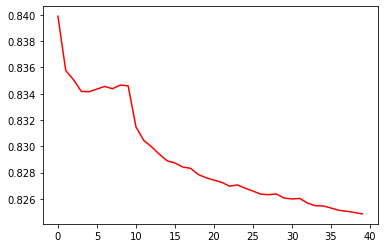

In [10]:
optimizer = optim.Adam(model.parameters(), lr=LR/10)
model_loader.optimizer = optimizer
model_loader.model = model_loader.best_model
model = model_loader.fit_transform(train_loader,loss_function = loss_function,epoch_num = 30,save_path = model_path)

  0%|          | 0/30 [00:00<?, ?it/s]

Learning Rate is : 0.0001


  3%|▎         | 1/30 [02:52<1:23:12, 172.14s/it]

Epoch:  1  loss:  0.8242647516002047


  7%|▋         | 2/30 [05:47<1:21:08, 173.86s/it]

Epoch:  2  loss:  0.8242030479655631


 10%|█         | 3/30 [07:31<1:03:54, 142.02s/it]

Epoch:  3  loss:  0.8239827608296995


 13%|█▎        | 4/30 [09:11<54:20, 125.40s/it]  

Epoch:  4  loss:  0.8238399368703139


 17%|█▋        | 5/30 [11:49<57:07, 137.08s/it]

Epoch:  5  loss:  0.8239117580809147


 20%|██        | 6/30 [14:07<55:00, 137.52s/it]

Epoch:  6  loss:  0.8240644118342745


 23%|██▎       | 7/30 [16:38<54:27, 142.05s/it]

Epoch:  7  loss:  0.8238019386754897


 27%|██▋       | 8/30 [19:27<55:11, 150.51s/it]

Epoch:  8  loss:  0.8238949791495024


 30%|███       | 9/30 [22:03<53:18, 152.32s/it]

Epoch:  9  loss:  0.8238725688640043


 33%|███▎      | 10/30 [24:38<51:04, 153.23s/it]

Epoch:  10  loss:  0.823741525424374


 37%|███▋      | 11/30 [26:27<44:12, 139.61s/it]

Epoch:  11  loss:  0.8237093362634489


 40%|████      | 12/30 [28:55<42:39, 142.18s/it]

Epoch:  12  loss:  0.8236060444636437


 43%|████▎     | 13/30 [31:27<41:06, 145.08s/it]

Epoch:  13  loss:  0.8235944267955605


 47%|████▋     | 14/30 [34:11<40:10, 150.66s/it]

Epoch:  14  loss:  0.8237478354431398


 50%|█████     | 15/30 [36:39<37:30, 150.07s/it]

Epoch:  15  loss:  0.8234745545035539


 53%|█████▎    | 16/30 [37:57<29:55, 128.27s/it]

Epoch:  16  loss:  0.8236050135081179


 57%|█████▋    | 17/30 [40:38<29:55, 138.08s/it]

Epoch:  17  loss:  0.8236908606316548


 60%|██████    | 18/30 [41:48<23:31, 117.63s/it]

Epoch:  18  loss:  0.8236973053673066


 63%|██████▎   | 19/30 [44:35<24:18, 132.59s/it]

Epoch:  19  loss:  0.823541965347894


 67%|██████▋   | 20/30 [47:22<23:47, 142.70s/it]

Epoch:  20  loss:  0.8236380034273477


 70%|███████   | 21/30 [49:05<19:39, 131.04s/it]

Epoch:  21  loss:  0.8236355502854622


 73%|███████▎  | 22/30 [51:14<17:21, 130.21s/it]

Epoch:  22  loss:  0.823352982120034


 77%|███████▋  | 23/30 [53:03<14:28, 124.08s/it]

Epoch:  23  loss:  0.823611778634771


 80%|████████  | 24/30 [54:23<11:04, 110.68s/it]

Epoch:  24  loss:  0.8233150211889733


 83%|████████▎ | 25/30 [55:59<08:51, 106.31s/it]

Epoch:  25  loss:  0.8234573506749802


 87%|████████▋ | 26/30 [58:46<08:18, 124.55s/it]

Epoch:  26  loss:  0.8234526550926479


 90%|█████████ | 27/30 [1:00:46<06:09, 123.05s/it]

Epoch:  27  loss:  0.8232991386896115


 93%|█████████▎| 28/30 [1:02:14<03:45, 112.61s/it]

Epoch:  28  loss:  0.8234465933614352


 97%|█████████▋| 29/30 [1:04:22<01:57, 117.36s/it]

Epoch:  29  loss:  0.8234868382001619


100%|██████████| 30/30 [1:07:21<00:00, 134.73s/it]

Epoch:  30  loss:  0.823366561602769


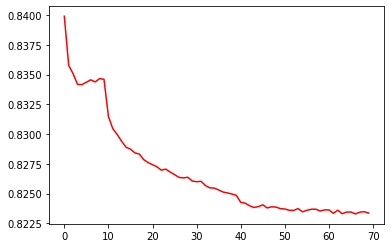

In [11]:
optimizer = optim.Adam(model.parameters(), lr=LR/100)
model_loader.optimizer = optimizer
model_loader.model = model_loader.best_model
model = model_loader.fit_transform(train_loader,loss_function = loss_function,epoch_num = 30,save_path = model_path)

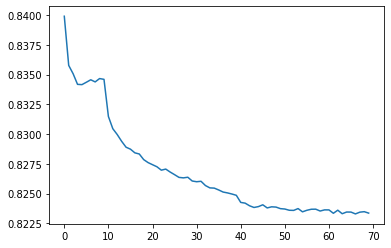

In [13]:
plt.plot(model_loader.loss_list)

In [12]:
final = model_loader.pred(test_loader)
final

,0
0,-0.042034
1,-0.099485
2,-0.061760
3,-0.043246
4,0.005575
...,...
402675,-0.068636
402676,-0.103985
402677,-0.176868
402678,-0.035640


In [14]:
final = pd.concat([target_list.reset_index(),final],axis=1)
final.rename(columns={0:Alpha_Name,'ticker': 'symbol'},inplace=True)
# final.set_index(["timestamp","symbol"],inplace=True)
final

,timestamp,symbol,target,AlphaNet_Original_Input_5d_return
0,2021-01-04 09:30:00,1,1.615797,-0.042034
1,2021-01-05 09:30:00,1,2.360776,-0.099485
2,2021-01-06 09:30:00,1,2.329058,-0.061760
3,2021-01-07 09:30:00,1,1.243396,-0.043246
4,2021-01-08 09:30:00,1,1.242059,0.005575
...,...,...,...,...
402675,2021-05-25 09:30:00,688981,-0.021415,-0.068636
402676,2021-05-26 09:30:00,688981,-0.242552,-0.103985
402677,2021-05-27 09:30:00,688981,-0.295931,-0.176868
402678,2021-05-28 09:30:00,688981,-0.502222,-0.035640


In [15]:
final.to_parquet(output_path
                + test_timestamp[0].split("_")[0] + "_" + test_timestamp[-1].split("_")[-1])